Import all the libraries

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



In [77]:
df = pd.read_csv('fitness_class_2212.csv', index_col='booking_id')
df.head()

,months_as_member,weight,days_before,day_of_week,time,category,attended
booking_id,,,,,,,
1,17,79.56,8,Wed,PM,Strength,0
2,10,79.01,2,Mon,AM,HIIT,0
3,16,74.53,14,Sun,AM,Strength,0
4,5,86.12,10,Fri,AM,Cycling,0
5,15,69.29,8,Thu,AM,HIIT,0


In [78]:
def analyze_dataframe(df):
    """
    Basic dataframe analysis
     
    """    
    stats = []
    
    for col in df.columns:
        # Basic info
        dtype = df[col].dtype
        missing = df[col].isnull().sum()
        missing_pct = (missing / len(df)) * 100
        unique_count = df[col].nunique()
        unique_pct = (unique_count / len(df)) * 100
        
        # Determine if column is categorical or numerical
        is_numeric = pd.api.types.is_numeric_dtype(df[col])
        col_type = 'Numerical' if is_numeric else 'Categorical'
            
        # Most frequent value and its count
        most_common = df[col].mode().iloc[0] if not df[col].empty else None
        most_common_count = df[col].value_counts().iloc[0] if not df[col].empty else 0
        
        # Compile information
        col_stats = {
            'Column': col,
            'Type': col_type,
            'Dtype': dtype,
            'Missing Values': missing,
            'Missing (%)': round(missing_pct, 2),
            'Unique Values': unique_count,
            'Unique (%)': round(unique_pct, 2),
            'Most Common': most_common,
            'Most Common Count': most_common_count
        }
        
        stats.append(col_stats)
    
    # Create DataFrame from collected statistics
    summary_df = pd.DataFrame(stats)
    
    # Define column order
    column_order = ['Column', 'Type', 'Dtype', 'Missing Values', 'Missing (%)',
                   'Unique Values', 'Unique (%)', 'Most Common', 'Most Common Count']
    
    summary_df = summary_df[column_order]
    
    return summary_df

analyze_dataframe(df)

,Column,Type,Dtype,Missing Values,Missing (%),Unique Values,Unique (%),Most Common,Most Common Count
0,months_as_member,Numerical,int64,0,0.00,72,4.80,8,99
1,weight,Numerical,float64,20,1.33,1241,82.73,78.28,5
2,days_before,Categorical,object,0,0.00,31,2.07,10,293
3,day_of_week,Categorical,object,0,0.00,10,0.67,Fri,279
4,time,Categorical,object,0,0.00,2,0.13,AM,1141
5,category,Categorical,object,0,0.00,6,0.40,HIIT,667
6,attended,Numerical,int64,0,0.00,2,0.13,0,1046


### PREPROCESSING

#### Inconsistencies

In [79]:
df["days_before"].value_counts()

days_before
10         293
2          199
8          194
12         178
14         172
4          154
6           70
7           38
3           31
5           30
11          26
13          25
15          24
9           24
1            9
10 days      6
14 days      3
12 days      3
6 days       3
4 days       3
16           3
17           3
20           1
2 days       1
5 days       1
7 days       1
8 days       1
1 days       1
3 days       1
13 days      1
29           1
Name: count, dtype: int64

We can see some of the days_before has "days" string init, so lets remove this and convert them to integer. 

In [80]:
df['days_before'] = df['days_before'].apply(lambda x: x.split()[0]).astype('int64')

Coverting full day names to abbreviated versions

In [81]:
df['day_of_week'] = df['day_of_week'].apply(lambda x: x[:3])

Replacing any dash ('-') in the category column with the word 'Other'

In [82]:
df['category'] = df['category'].replace('-', 'Other')

#### Missing Values

Handeling the missing values for weight

In [83]:
# Step 1: Calculate mean weight for each category
category_means = df.groupby('category')['weight'].transform('mean').round()

# Step 2: Fill NaN values with the calculated means
df['weight'] = df['weight'].fillna(category_means) # Fill any missing weights with their category's mean

In [84]:
import tabulate
print(tabulate.tabulate(df.head(),headers=df.columns))

      months_as_member    weight    days_before  day_of_week    time    category      attended
--  ------------------  --------  -------------  -------------  ------  ----------  ----------
 1                  17     79.56              8  Wed            PM      Strength             0
 2                  10     79.01              2  Mon            AM      HIIT                 0
 3                  16     74.53             14  Sun            AM      Strength             0
 4                   5     86.12             10  Fri            AM      Cycling              0
 5                  15     69.29              8  Thu            AM      HIIT                 0


### EDA

Numerical data visualization

In [86]:
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns
target = df["attended"]

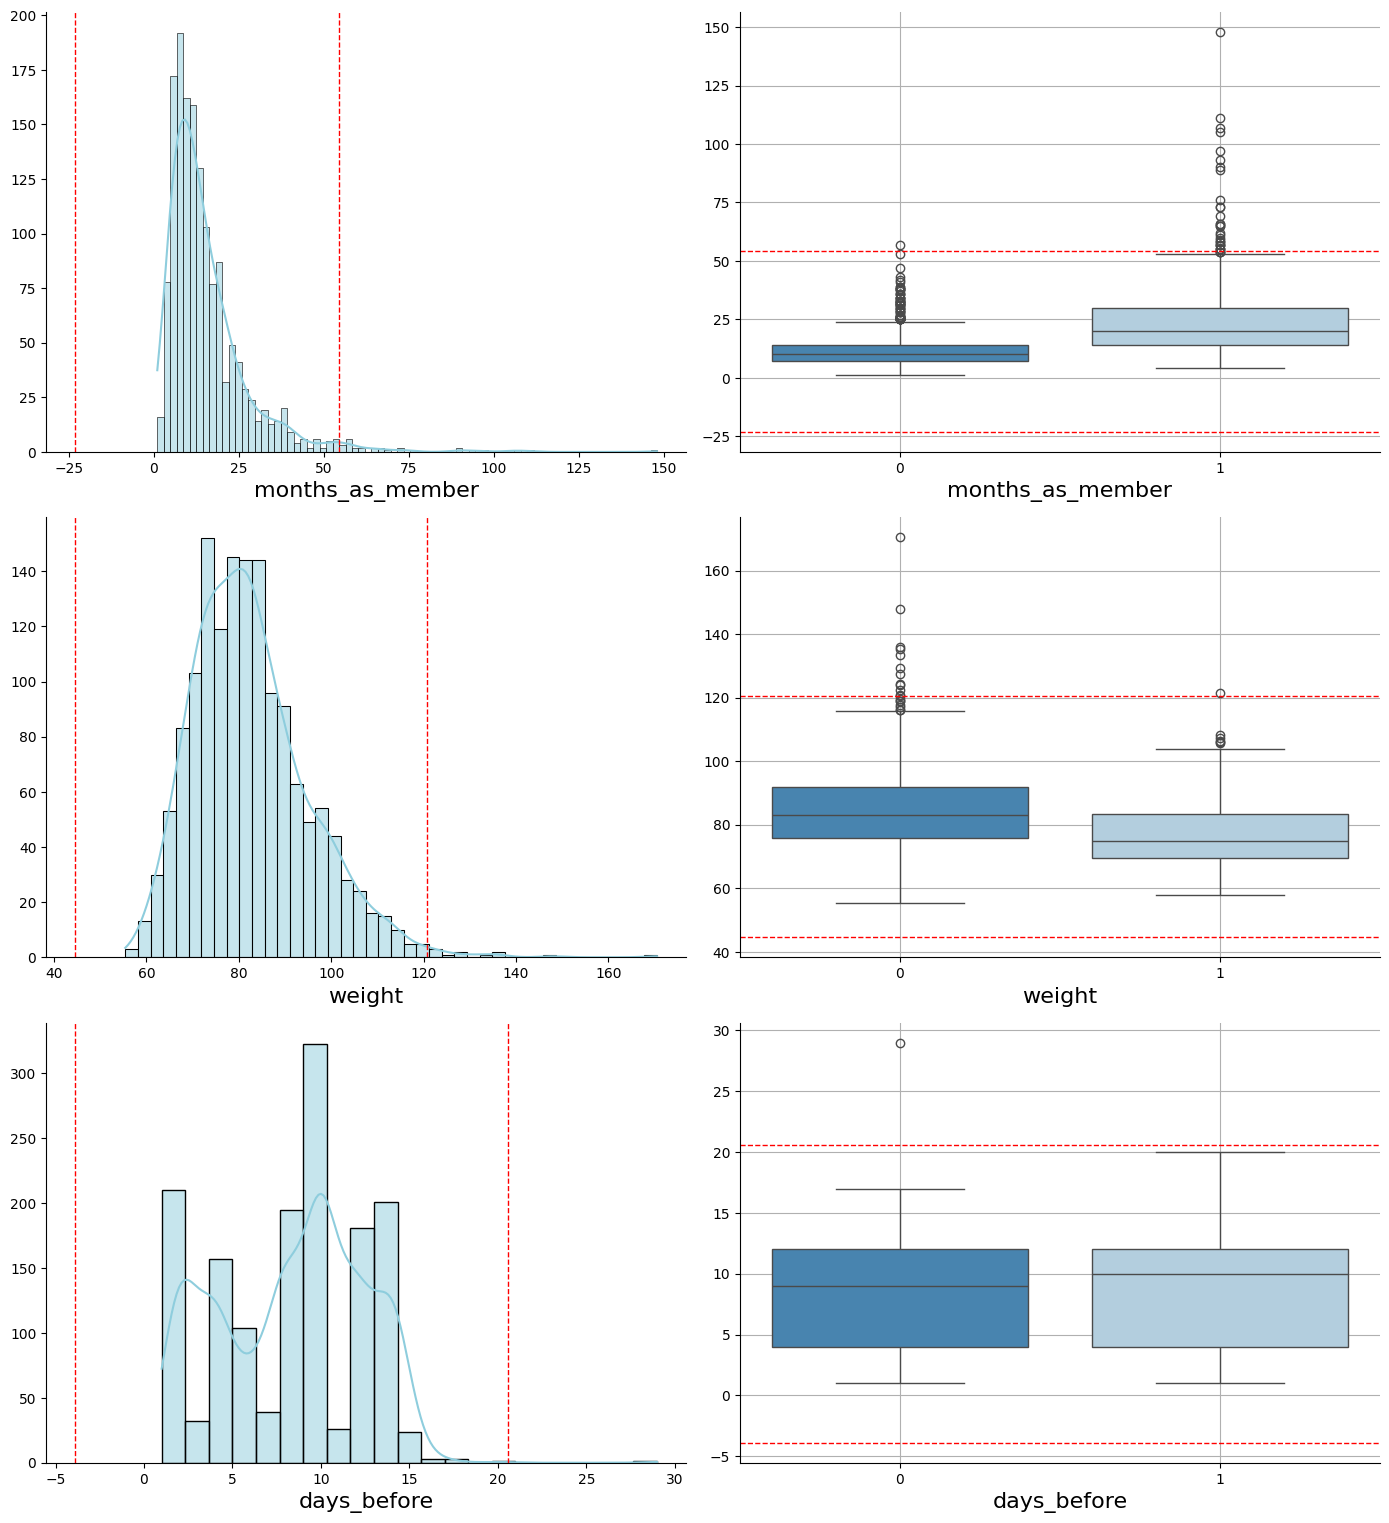

In [91]:
data = df[num_cols.drop("attended")]
plt.figure(figsize=(14, 30))

for index, feature in enumerate(data.columns):
    mean = data[feature].mean()
    std = data[feature].std()
    
    plt.subplot(6, 2, index * 2 + 1)
    sns.histplot(data=data, x=feature, kde=True, color='#8ECDDD')
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('')
    
    plt.axvline(mean - 3 * std, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(mean + 3 * std, color='red', linestyle='dashed', linewidth=1)

    plt.subplot(6, 2, index * 2 + 2)
    sns.boxplot(data=pd.concat([data, target], axis=1), x=target, y=feature, palette='Blues_r')
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('')
    plt.grid(True)
    
    plt.axhline(mean - 3 * std, color='red', linestyle='dashed', linewidth=1)
    plt.axhline(mean + 3 * std, color='red', linestyle='dashed', linewidth=1)
    
    sns.despine(right=True, top=True)

plt.tight_layout()
plt.show()

Removing Numerical outliers: 

In [92]:
df.loc[df['months_as_member'] > 100, 'months_as_member'] = 100
df.loc[df['days_before'] > 20, 'days_before'] = 20
df.loc[df['weight'] > 140, 'weight'] = 140

Categorical data visualization

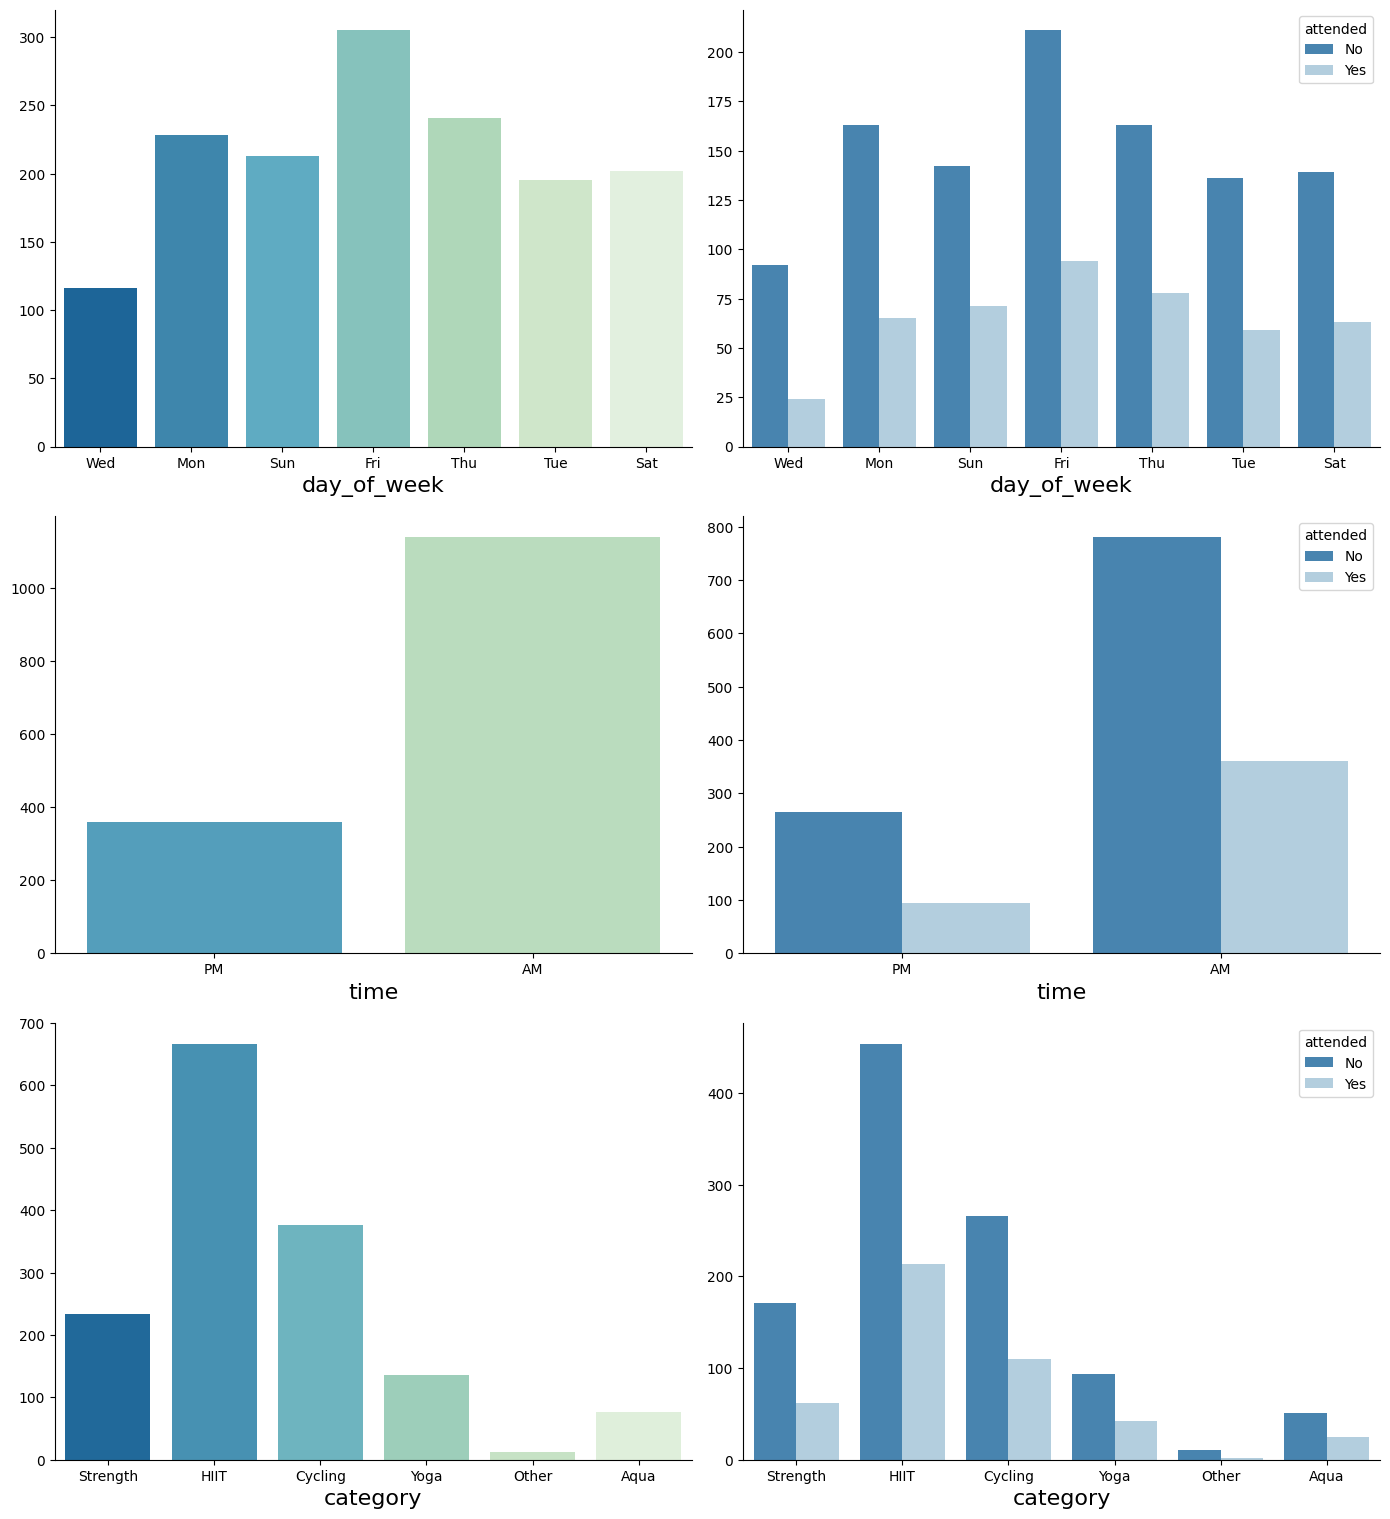

In [93]:
data = df[cat_cols]
plt.figure(figsize=(14, 30))

for index, feature in enumerate(data.columns):
    
    plt.subplot(6, 2, index * 2 + 1)
    sns.countplot(data=data, x=feature, palette='GnBu_r')
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('')

    plt.subplot(6, 2, index * 2 + 2)
    sns.countplot(data=pd.concat([data, target], axis=1), x=feature, hue="attended", palette="Blues_r")
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('')
    plt.legend(title="attended", labels=["No", "Yes"])
    
    sns.despine(right=True, top=True)

plt.tight_layout()
plt.show()

Target Column Visualization

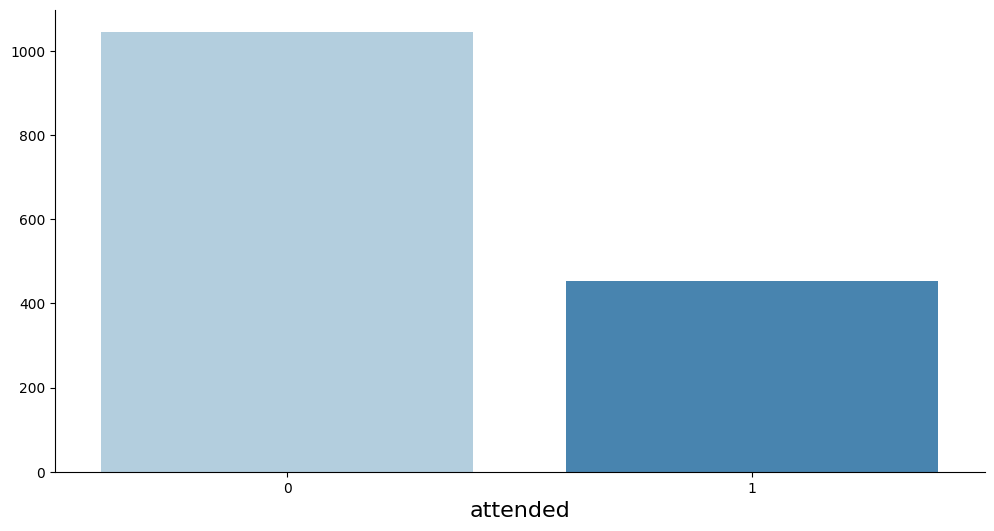

In [94]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df["attended"], palette="Blues")
plt.xlabel('attended', fontsize=16)
plt.ylabel('')
sns.despine(right=True, top=True)
plt.show()

### Feature Engineering 

In [11]:

dummy_features = pd.get_dummies(df[['time', 'category']], drop_first=True)
df = pd.concat([df.drop(columns=['time', 'category']), dummy_features], axis=1)



In [12]:
# cyclical encoding for days of week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_numeric'] = df['day_of_week'].apply(lambda x: days.index(x) / len(days))

df['sin_day'] = np.sin(2 * np.pi * df['day_numeric'])
df['cos_day'] = np.cos(2 * np.pi * df['day_numeric'])
df = df.drop(columns=['day_of_week', 'day_numeric'])


In [13]:
# log transformation for months_as_member and weight
df['log_months_as_member'] = np.log(df['months_as_member'])
df['log_weight'] = np.log(df['weight'])
df = df.drop(columns=['months_as_member', 'weight'])

In [14]:
df.head(3)

,days_before,attended,time_PM,category_Cycling,category_HIIT,category_Other,category_Strength,category_Yoga,sin_day,cos_day,log_months_as_member,log_weight
booking_id,,,,,,,,,,,,
1,8,0,True,False,False,False,True,False,0.974928,-0.222521,2.833213,4.376511
2,2,0,False,False,True,False,False,False,0.000000,1.000000,2.302585,4.369574
3,14,0,False,False,False,False,True,False,-0.781831,0.623490,2.772589,4.311202


## PART I 

a.       Sample a subset of the data based on class label

In [15]:
from sklearn.model_selection import train_test_split

# Assuming 'attended' is your class label
X = df.drop('attended', axis=1)
y = df['attended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


print("Class distribution in training set:")
y_train.value_counts(normalize=True)

Training set shape: (1200, 11)
Testing set shape: (300, 11)
Class distribution in training set:


attended
0    0.6975
1    0.3025
Name: proportion, dtype: float64

Lets perform undersampling to balance the dataset and get the subset

In [42]:
target_size = y_train.value_counts().min()

sampling_strategy = {0: target_size // 2, 1: target_size // 2}  # Equal split

ros = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_sample, y_train_sample = ros.fit_resample(X_train, y_train)


b.	Apply PCA and LDA and visualize the results

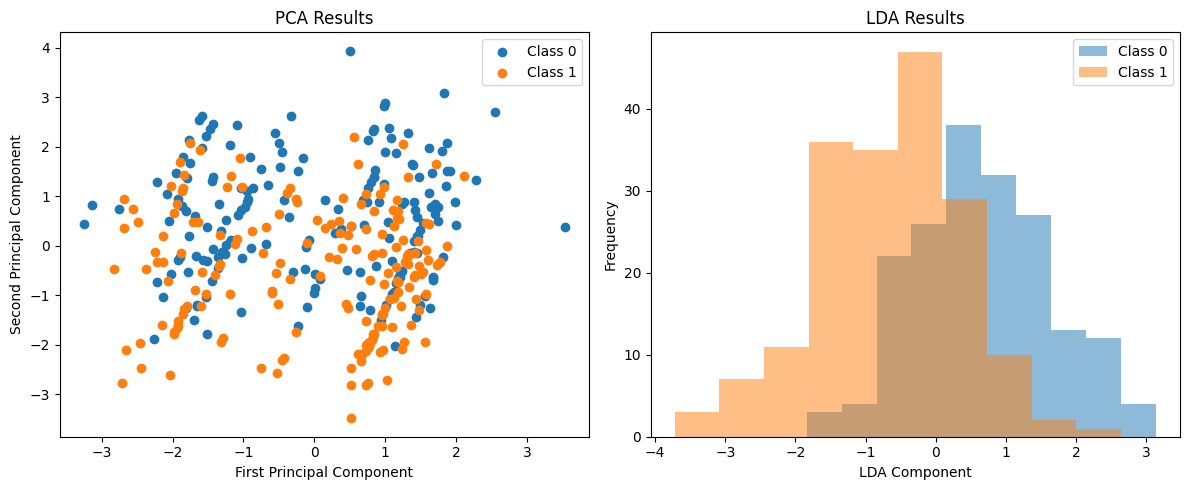

PCA explained variance ratio: [0.17300912 0.15210322]


In [47]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.transform(X_test)

##################### PCA ##########################
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[y_train_sample==0, 0], X_train_pca[y_train_sample==0, 1], label='Class 0')
plt.scatter(X_train_pca[y_train_sample==1, 0], X_train_pca[y_train_sample==1, 1], label='Class 1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Results')
plt.legend()


##################### LDA ############################
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_sample)
plt.subplot(1, 2, 2)
plt.hist(X_train_lda[y_train_sample==0], alpha=0.5, label='Class 0')
plt.hist(X_train_lda[y_train_sample==1], alpha=0.5, label='Class 1')
plt.xlabel('LDA Component')
plt.ylabel('Frequency')
plt.title('LDA Results')
plt.legend()

plt.tight_layout()
plt.show()

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

In [48]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
   from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
   import matplotlib.pyplot as plt
   import seaborn as sns
   
   #################### Train / Test ##########################
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   y_prob = model.predict_proba(X_test)[:, 1]
   
   #################### confusion_matrix  ##########################
   
   cm = confusion_matrix(y_test, y_pred)
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
   plt.title('Confusion Matrix')
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   plt.show()
   
  #################### classification_report  ##########################

   print(classification_report(y_test, y_pred))
   
   
  #################### ROC Curve  ##########################
   fpr, tpr, _ = roc_curve(y_test, y_prob)
   roc_auc = auc(fpr, tpr)
   
   plt.figure(figsize=(10, 5))
   plt.subplot(1, 2, 1)
   plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
   plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title('ROC Curve')
   plt.legend(loc="lower right")
   
   #################### PR curve  ##########################

   precision, recall, _ = precision_recall_curve(y_test, y_prob)
   pr_auc = auc(recall, precision)
   
   plt.subplot(1, 2, 2)
   plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('Recall')
   plt.ylabel('Precision')
   plt.title('Precision-Recall Curve')
   plt.legend(loc="lower left")
   plt.tight_layout()
   plt.show()
   
   return model

#### Training GaussianNB

1. Subet of data: 

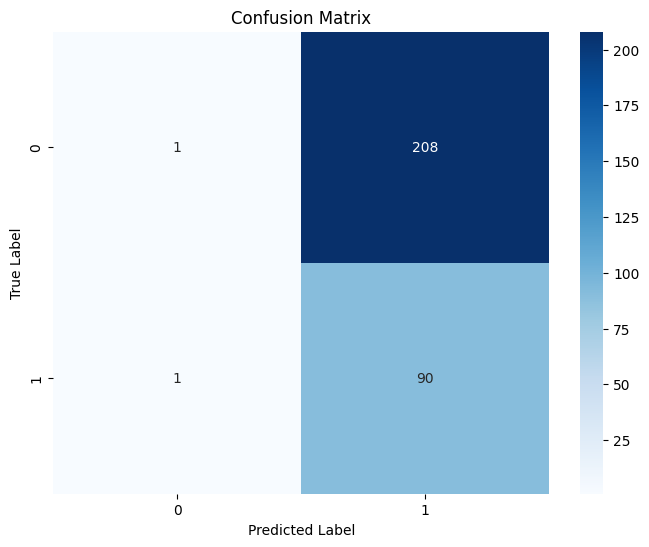

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       209
           1       0.30      0.99      0.46        91

    accuracy                           0.30       300
   macro avg       0.40      0.50      0.24       300
weighted avg       0.44      0.30      0.15       300



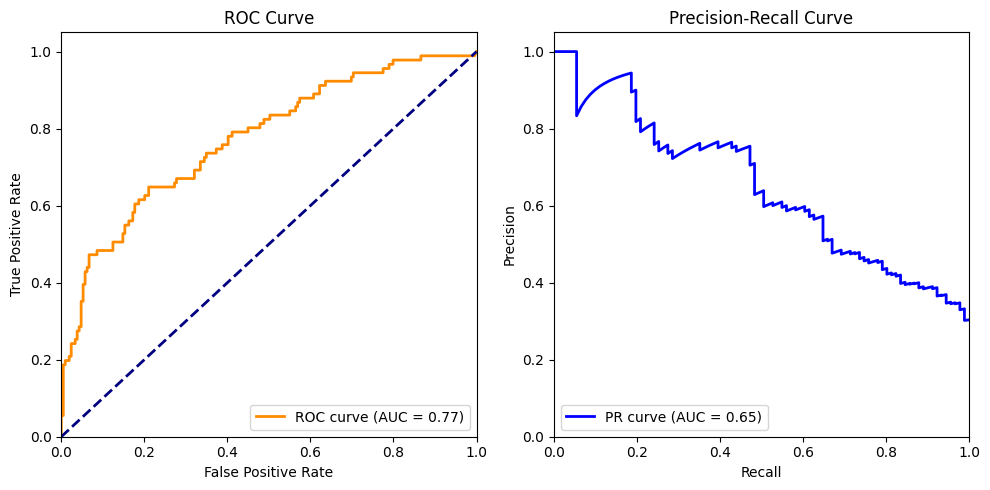

In [ ]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings(action="ignore")

model_gb = model_evaluation(GaussianNB(),X_train_sample, y_train_sample,X_test,y_test)

2. Subset + PCA on data

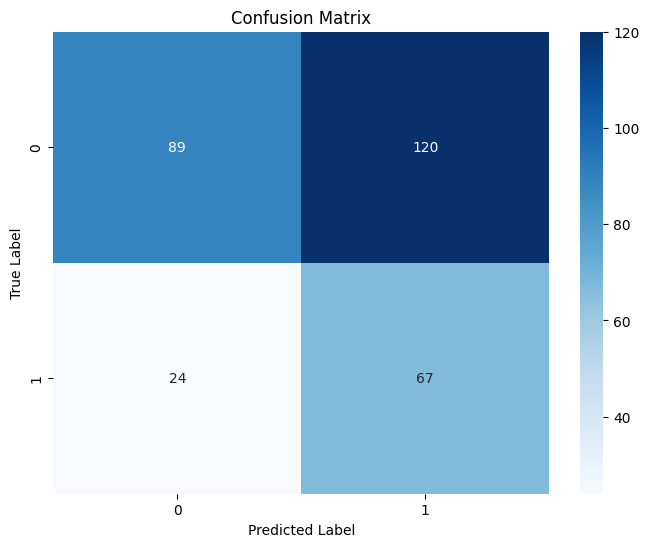

              precision    recall  f1-score   support

           0       0.79      0.43      0.55       209
           1       0.36      0.74      0.48        91

    accuracy                           0.52       300
   macro avg       0.57      0.58      0.52       300
weighted avg       0.66      0.52      0.53       300



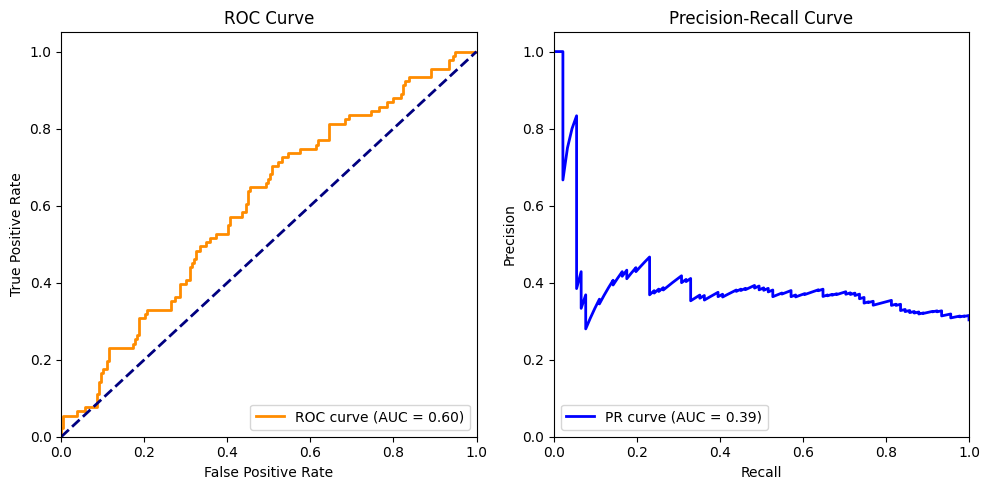

In [ ]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings(action="ignore")

model_gb = model_evaluation(GaussianNB(),X_train_pca, y_train_sample,X_test_pca,y_test)

#### Training LogisticRegression 
1. Subset of data:

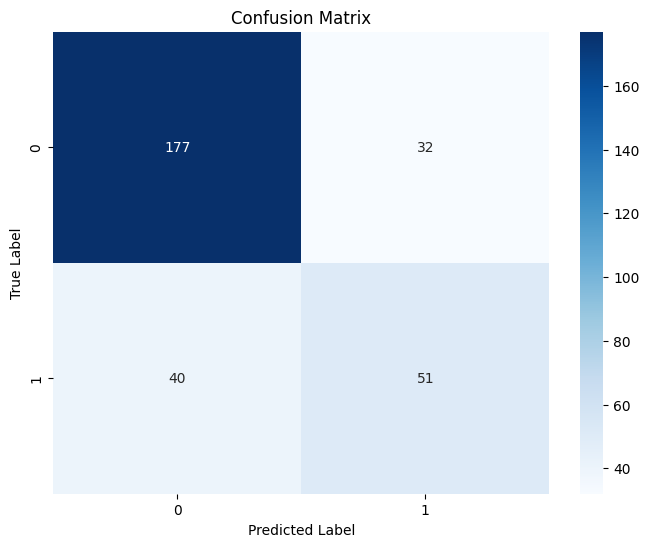

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       209
           1       0.61      0.56      0.59        91

    accuracy                           0.76       300
   macro avg       0.72      0.70      0.71       300
weighted avg       0.75      0.76      0.76       300



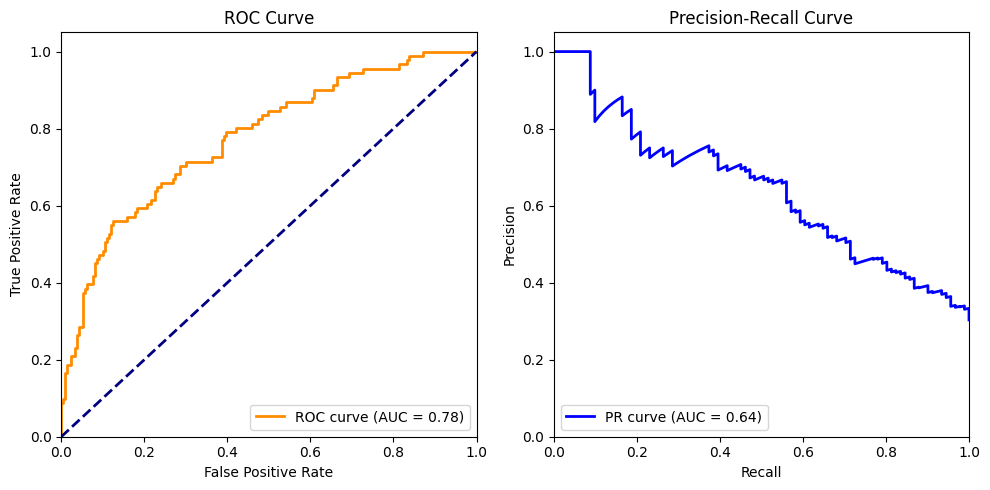

In [51]:
from sklearn.linear_model import LogisticRegression 

model_lr = model_evaluation(LogisticRegression(random_state=42),X_train_sample, y_train_sample,X_test_scaled,y_test)

2. Subset + PCA

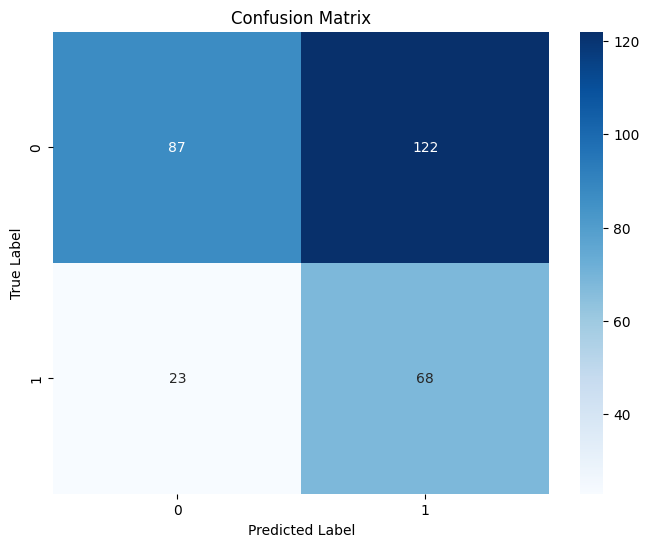

              precision    recall  f1-score   support

           0       0.79      0.42      0.55       209
           1       0.36      0.75      0.48        91

    accuracy                           0.52       300
   macro avg       0.57      0.58      0.51       300
weighted avg       0.66      0.52      0.53       300



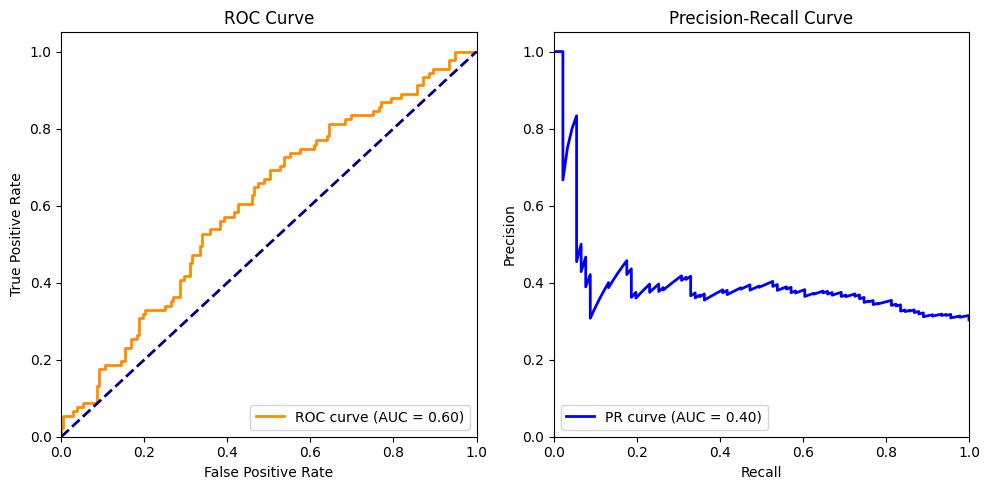

In [52]:
model_lr = model_evaluation(LogisticRegression(random_state=42),X_train_pca, y_train_sample,X_test_pca,y_test)

#### Training SVM

1. Subset of data:

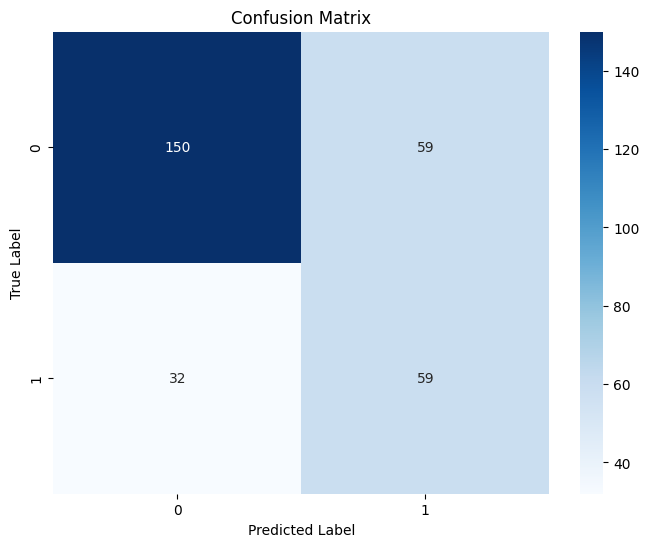

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       209
           1       0.50      0.65      0.56        91

    accuracy                           0.70       300
   macro avg       0.66      0.68      0.67       300
weighted avg       0.73      0.70      0.71       300



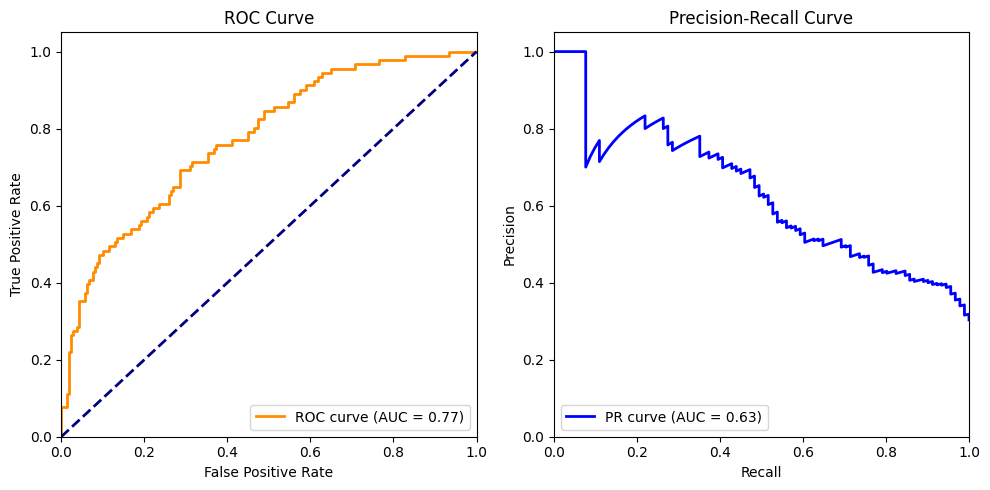

In [53]:
from sklearn.svm import SVC
model_svc = model_evaluation( SVC(probability=True, random_state=42),X_train_sample, y_train_sample,X_test,y_test)

2. Subset + PCA

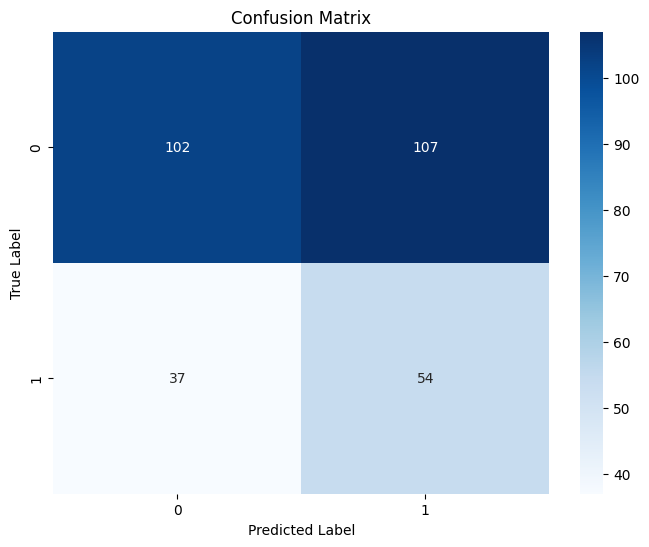

              precision    recall  f1-score   support

           0       0.73      0.49      0.59       209
           1       0.34      0.59      0.43        91

    accuracy                           0.52       300
   macro avg       0.53      0.54      0.51       300
weighted avg       0.61      0.52      0.54       300



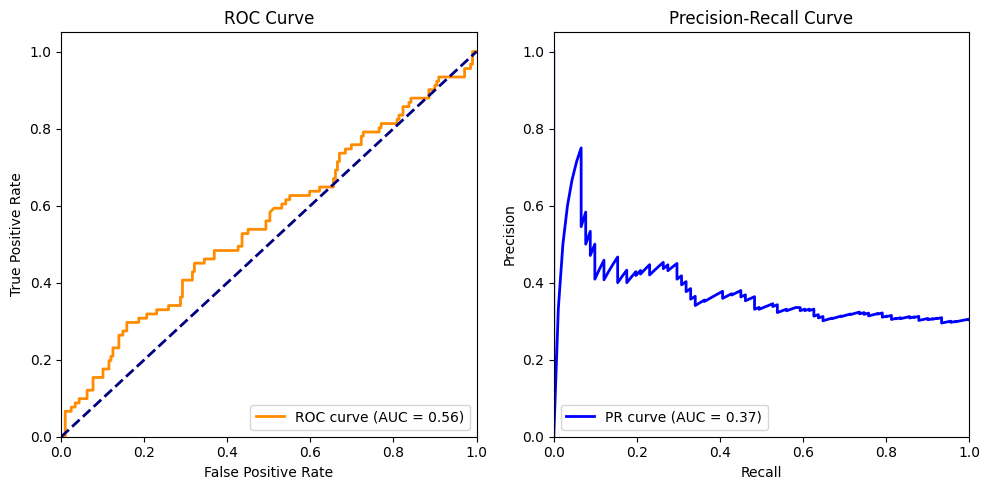

In [54]:
from sklearn.svm import SVC
model_svc = model_evaluation( SVC(probability=True, random_state=42),X_train_pca, y_train_sample,X_test_pca,y_test)

## Part II

a.	Apply PCA and LDA. For PCA, plot the incremental gain in capturing the variance in the data for each successive principal component that is added and compare this with the subset of data in step 1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)
y_train.value_counts(normalize=True)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

############################ PCA + LDA + Incremental Gain ##############################################
# ???????????????????????????????????????????????????????????????????????????????/

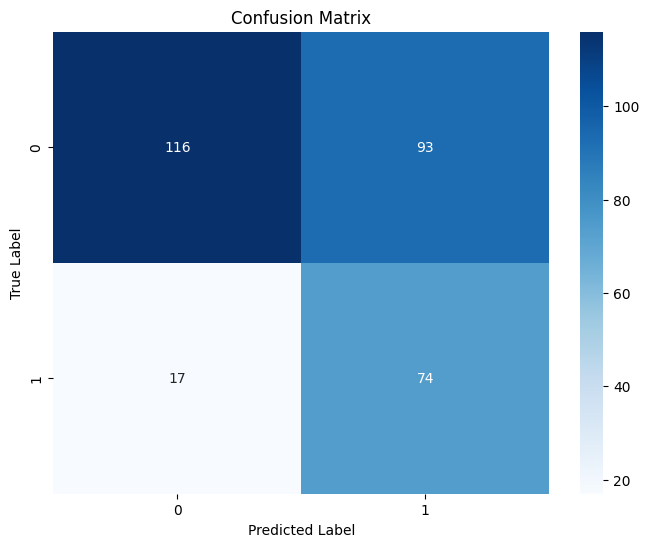

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       209
           1       0.44      0.81      0.57        91

    accuracy                           0.63       300
   macro avg       0.66      0.68      0.63       300
weighted avg       0.74      0.63      0.65       300



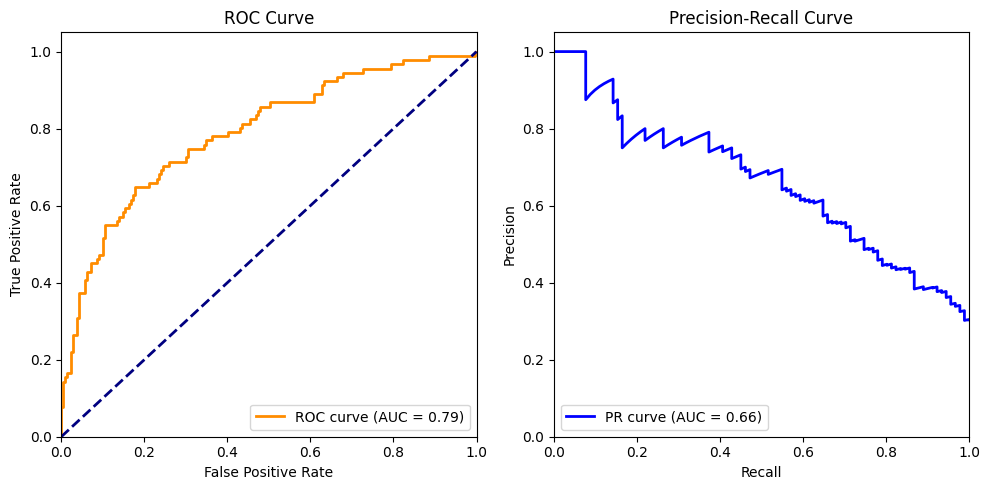

In [67]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings(action="ignore")

model_gb = model_evaluation(GaussianNB(),X_train_scaled, y_train,X_test_scaled,y_test)

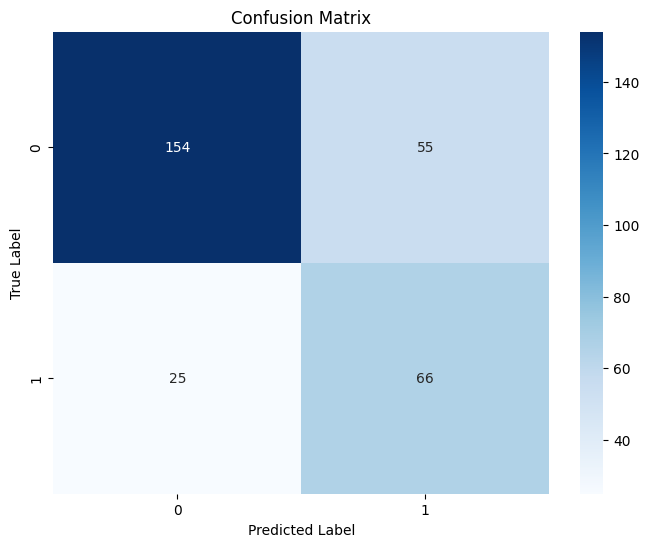

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       209
           1       0.55      0.73      0.62        91

    accuracy                           0.73       300
   macro avg       0.70      0.73      0.71       300
weighted avg       0.76      0.73      0.74       300



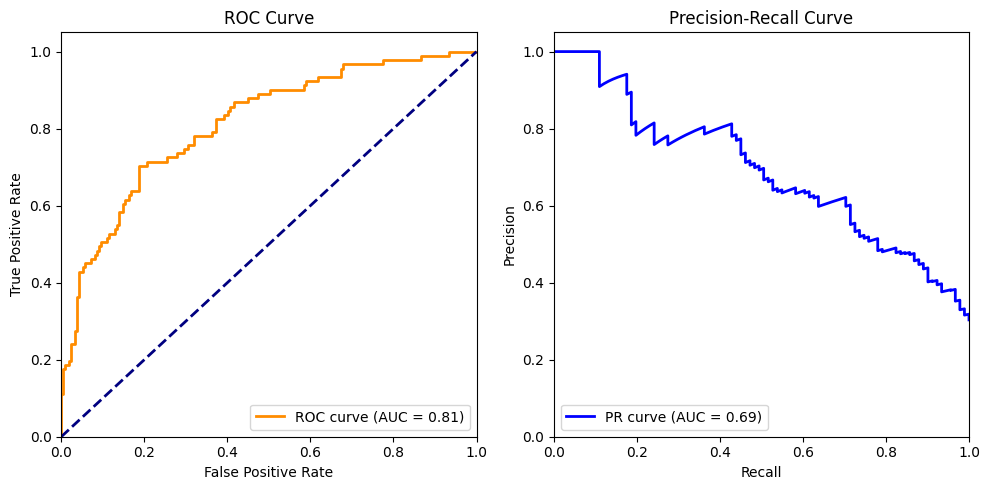

In [68]:
from sklearn.linear_model import LogisticRegression 

model_lr = model_evaluation(LogisticRegression(random_state=42),X_train_scaled, y_train,X_test_scaled,y_test)

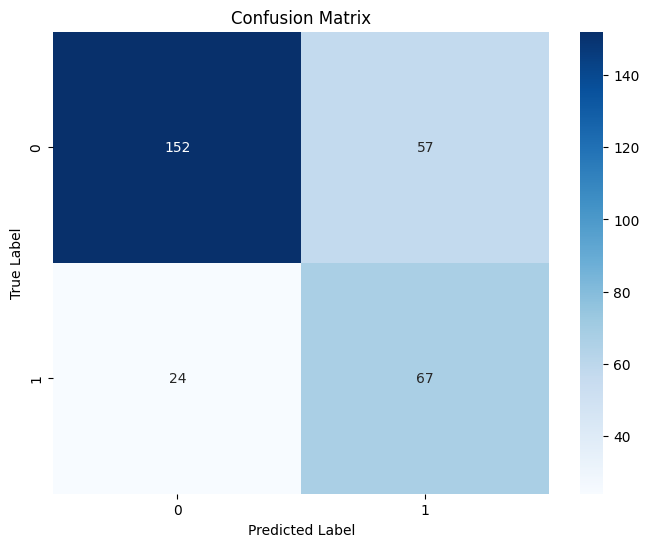

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       209
           1       0.54      0.74      0.62        91

    accuracy                           0.73       300
   macro avg       0.70      0.73      0.71       300
weighted avg       0.77      0.73      0.74       300



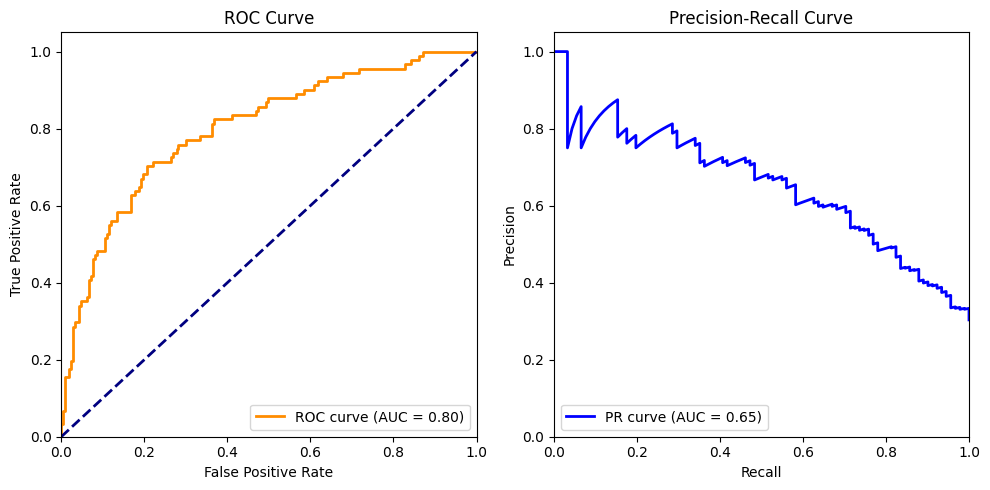

In [69]:
from sklearn.svm import SVC
model_svc = model_evaluation( SVC(probability=True, random_state=42),X_train_scaled, y_train,X_test_scaled,y_test)

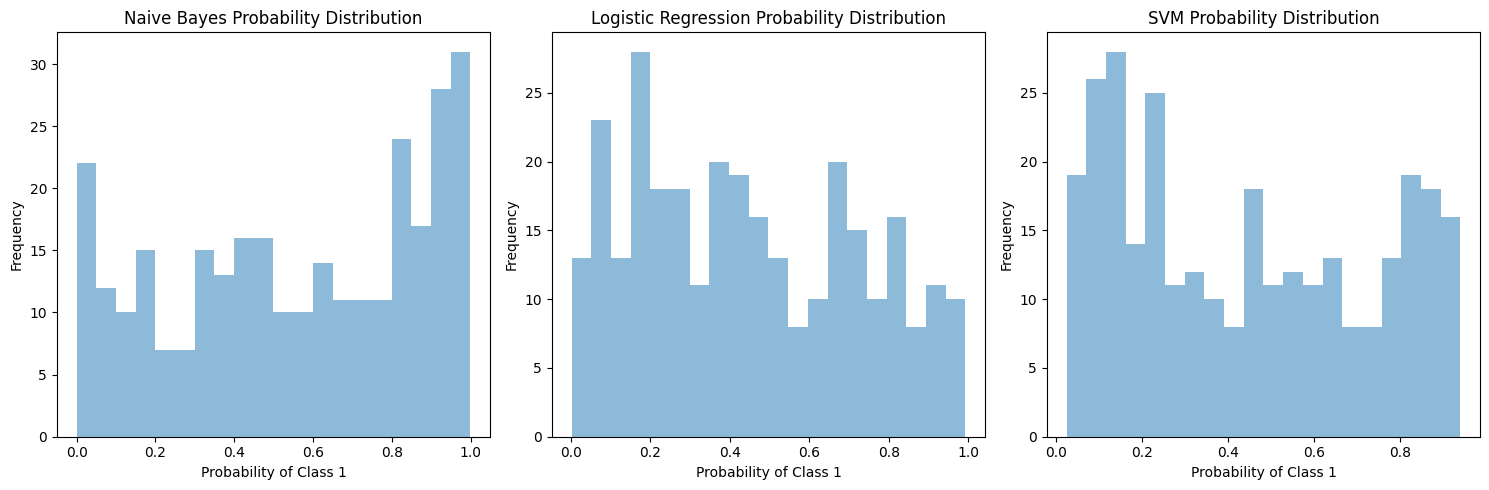

In [70]:
nb_probs = model_gb.predict_proba(X_test_scaled)
lr_probs = model_lr.predict_proba(X_test_scaled)
svm_probs = model_svc.predict_proba(X_test_scaled)


plt.figure(figsize=(15, 5))

# Naive Bayes probabilities
plt.subplot(1, 3, 1)
plt.hist(nb_probs[:, 1], bins=20, alpha=0.5)
plt.title('Naive Bayes Probability Distribution')
plt.xlabel('Probability of Class 1')
plt.ylabel('Frequency')

# Logistic Regression probabilities
plt.subplot(1, 3, 2)
plt.hist(lr_probs[:, 1], bins=20, alpha=0.5)
plt.title('Logistic Regression Probability Distribution')
plt.xlabel('Probability of Class 1')
plt.ylabel('Frequency')

# SVM probabilities
plt.subplot(1, 3, 3)
plt.hist(svm_probs[:, 1], bins=20, alpha=0.5)
plt.title('SVM Probability Distribution')
plt.xlabel('Probability of Class 1')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

| Criteria | Naive Bayes | Logistic Regression | SVM |
|----------|-------------|-------------------|-----|
| Distribution Pattern | High peak at 0.0, smaller peaks at 0.8-1.0 | Multiple peaks with more uniform spread | More balanced distribution across probabilities |
| Confidence | Overly confident in negative class (0.0) | Balanced but scattered confidence | More consistent confidence levels |
| Decision Boundary | Sharp separation towards 0.0 | Multiple decision thresholds | Smoother probability transition |

Model Choice: 
* Here we take Logistic Regression as the best model the probability distirbution is more closer to uniform distribution with some consitent peaks where SVM is showing clustered predictions. This means the model was able to capture small difference between classes. LR is also not overly confident compared to Naive Bayes which is showing strong bias towards positive class.  


Optional
    a.	Based on a 7-dimensional vector of confidence values for face identity, plot the position of these in a 2D embedding. The “points” that are shown should be the actual face images within the plot.
